# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# План работ

1) Загрузим и изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, удалим их.

2) Подготовим выборки для обучения моделей.

3) Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.

4) Проанализируем время обучения, время предсказания и качество моделей.

5) Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.

## Подготовка данных

### Изучим данные

In [1]:
import pandas as pd 
import lightgbm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, make_scorer 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import time

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Есть пропуски в колонках с типом кузова, типом КПП, Модели, типом топлива и  была машина в ремонте или нет.



### Проведем предобработку данных

Заполним пропуски значением unknown

In [6]:
df.duplicated().sum()

4

В датасете присутствуют 4 дубликата, удалим их сразу

In [7]:
df = df.drop_duplicates().reset_index(drop = True)

Удалим ненужные для нашей задачи колонки из датасета

In [8]:
df = df.drop(['DateCrawled', 'PostalCode', 'LastSeen', 'NumberOfPictures', 'DateCreated'], axis=1)

In [9]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650
std,4514.176349,90.228466,189.851330,37905.083858,3.726432
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


Изучим целевой признак. Присутствуют нулевые значения, значит будем изучать детальней

<AxesSubplot:ylabel='Frequency'>

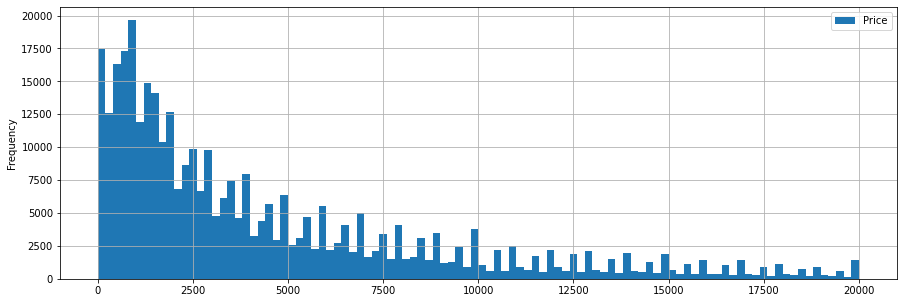

In [10]:
df.plot(kind='hist', y='Price', grid=True, bins=100, figsize=(15,5))

In [11]:
df.query('Price < 50').count()

Price                12423
VehicleType           7912
RegistrationYear     12423
Gearbox               9254
Power                12423
Model                 9881
Kilometer            12423
RegistrationMonth    12423
FuelType              8241
Brand                12423
Repaired              6132
dtype: int64

12423 c аномально низкими значениями, считаю правильным удалить их.

In [12]:
df = df.query('Price > 50')

In [13]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,341615.000000,341615.000000,341615.000000,341615.000000,341615.000000
mean,4581.441986,2004.035660,111.265682,128472.168962,5.794189
std,4514.847269,74.621408,188.253189,37291.246054,3.691497
min,55.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1200.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2900.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


Так же присутствуют аномальные значения в столбцах года и месяца регистрации, а так же мощности

In [14]:
df.query('Power == 0').count()

Price                35363
VehicleType          23683
RegistrationYear     35363
Gearbox              24829
Power                35363
Model                30633
Kilometer            35363
RegistrationMonth    35363
FuelType             26396
Brand                35363
Repaired             17504
dtype: int64

<AxesSubplot:ylabel='Frequency'>

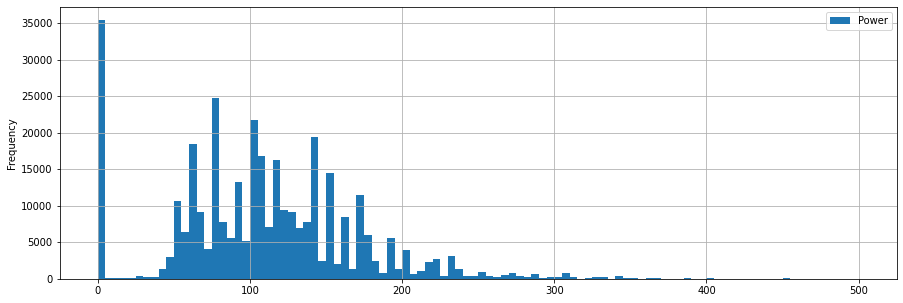

In [15]:
df.plot(kind='hist', y='Power', grid=True, bins=100, figsize=(15,5), range=(0, 500))

Удалим аномальные значения равные 0 и больше 500

In [16]:
df = df.query('0 < Power < 500')

Года выпуска тоже оставим в рамках разумного

In [17]:
df = df.query('1900 < RegistrationYear < 2023')

In [18]:
df['VehicleType'].fillna('unknown', inplace = True)
df['Gearbox'].fillna('unknown', inplace = True)
df['Model'].fillna('unknown', inplace = True)
df['FuelType'].fillna('unknown', inplace = True)
df['Repaired'].fillna('unknown', inplace = True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305772 entries, 1 to 354364
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              305772 non-null  int64 
 1   VehicleType        305772 non-null  object
 2   RegistrationYear   305772 non-null  int64 
 3   Gearbox            305772 non-null  object
 4   Power              305772 non-null  int64 
 5   Model              305772 non-null  object
 6   Kilometer          305772 non-null  int64 
 7   RegistrationMonth  305772 non-null  int64 
 8   FuelType           305772 non-null  object
 9   Brand              305772 non-null  object
 10  Repaired           305772 non-null  object
dtypes: int64(5), object(6)
memory usage: 28.0+ MB


In [20]:
df.isnull().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

## Обучение моделей

### Подготовим выборки для обучения моделей.

Закодируем категориальные признаки

In [21]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
1,18300,2011,190,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,7,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,10,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


Разобьем признаки на выборки

In [22]:
df_test_valid_ohe, df_test_ohe = train_test_split(df_ohe, test_size=0.2, random_state=42) 

In [23]:
df_valid_ohe, df_train_ohe = train_test_split(df_test_valid_ohe, test_size=0.75, random_state=42)

In [24]:
features_test_ohe = df_test_ohe.drop(['Price'], axis=1)
target_test_ohe = df_test_ohe['Price']
features_train_ohe = df_train_ohe.drop(['Price'], axis=1)
target_train_ohe = df_train_ohe['Price']
features_valid_ohe = df_valid_ohe.drop(['Price'], axis=1)
target_valid_ohe = df_valid_ohe['Price']

In [25]:
print(features_train_ohe.shape)
print(target_train_ohe.shape)
print(features_test_ohe.shape)
print(target_test_ohe.shape)
print(features_valid_ohe.shape)
print(target_valid_ohe.shape)
#проверим соотношение

(183463, 311)
(183463,)
(61155, 311)
(61155,)
(61154, 311)
(61154,)


Масштабируем признаки

In [28]:
num = list(df_ohe)
num.remove('Price') 

In [29]:
scaler = StandardScaler()
scaler.fit_transform(features_train_ohe[num])
features_valid_ohe = scaler.transform(features_valid_ohe[num])
features_train_ohe = scaler.transform(features_train_ohe[num])
features_test_ohe = scaler.transform(features_test_ohe[num])

In [30]:
features_train_ohe

array([[-0.04276855, -0.37652287,  0.58658989, ..., -0.09745379,
        -0.42489105, -0.32668876],
       [ 0.53276894,  0.8066289 ,  0.58658989, ..., -0.09745379,
         2.35354449, -0.32668876],
       [ 0.82053769, -0.63944549, -1.59735996, ..., -0.09745379,
         2.35354449, -0.32668876],
       ...,
       [ 0.10111582,  0.29956385,  0.58658989, ..., -0.09745379,
        -0.42489105, -0.32668876],
       [ 0.2450002 ,  1.06955151,  0.58658989, ..., -0.09745379,
        -0.42489105, -0.32668876],
       [-0.90607479,  2.15880235,  0.58658989, ..., -0.09745379,
         2.35354449, -0.32668876]])

### Обучим модель LinearRegression

In [31]:
%%time

model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe)
predictions_valid_ohe = model.predict(features_valid_ohe)
rmse = mean_squared_error(target_valid_ohe, predictions_valid_ohe)**0.5
print('RMSE:', rmse)

RMSE: 2579.8130816165963
CPU times: user 15.7 s, sys: 11.1 s, total: 26.8 s
Wall time: 26.9 s


### Обучим модель DecisionTreeRegressor

In [32]:
enc = OrdinalEncoder()
enc.fit(df[['VehicleType','RegistrationYear', 'Gearbox', 'Power', 
            'Model', 'Kilometer','FuelType',
            'Brand', 'Repaired']])
df[['VehicleType','RegistrationYear', 'Gearbox', 'Power', 
            'Model', 'Kilometer','FuelType',
            'Brand', 'Repaired']] = enc.transform(df[['VehicleType','RegistrationYear', 'Gearbox', 'Power', 
            'Model', 'Kilometer','FuelType',
            'Brand', 'Repaired']])

In [33]:
df_test_valid_oe, df_test_oe = train_test_split(df, test_size=0.2, random_state=42) 

In [34]:
df_valid_oe, df_train_oe = train_test_split(df_test_valid_oe, test_size=0.75, random_state=42)

In [35]:
features_test_oe = df_test_oe.drop(['Price'], axis=1)
target_test_oe = df_test_oe['Price']
features_train_oe = df_train_oe.drop(['Price'], axis=1)
target_train_oe = df_train_oe['Price']
features_valid_oe = df_valid_oe.drop(['Price'], axis=1)
target_valid_oe = df_valid_oe['Price']

In [36]:
print(features_train_oe.shape)
print(target_train_oe.shape)
print(features_test_oe.shape)
print(target_test_oe.shape)
print(features_valid_oe.shape)
print(target_valid_oe.shape)
#проверим соотношение

(183463, 10)
(183463,)
(61155, 10)
(61155,)
(61154, 10)
(61154,)


In [39]:
for depth in range(2, 20, 2):
    model = DecisionTreeRegressor(random_state=42, max_depth = depth)
    model.fit(features_train_oe, target_train_oe)
    predictions_valid_oe = model.predict(features_valid_oe)
    rmse = mean_squared_error(target_valid_oe, predictions_valid_oe)**0.5
    print('Глубина:', depth)
    print('RMSE:', rmse)
    print('-'*20)
print()

Глубина: 2
RMSE: 3262.753003898737
--------------------
Глубина: 4
RMSE: 2665.679789646077
--------------------
Глубина: 6
RMSE: 2309.9184444573007
--------------------
Глубина: 8
RMSE: 2102.938362866917
--------------------
Глубина: 10
RMSE: 1980.8526911892754
--------------------
Глубина: 12
RMSE: 1910.8750109040861
--------------------
Глубина: 14
RMSE: 1912.9077686466235
--------------------
Глубина: 16
RMSE: 1936.1462664750343
--------------------
Глубина: 18
RMSE: 1972.5312169306715
--------------------



Лучший результат RMSE = 1910 на глубине 12

### Обучим модель RandomForestRegressor

In [40]:
%%time

for est in [10, 20, 30, 40, 50, 60]:
    model = RandomForestRegressor(random_state=42, n_estimators=est, max_depth=12)
    model.fit(features_train_oe, target_train_oe)
    predictions_train_oe = model.predict(features_valid_oe)
    rmse = mean_squared_error(target_valid_oe, predictions_valid_oe)**0.5
    print('Количество деревьев:', est)
    print('RMSE:', rmse)
    print('-'*20)
print()

Количество деревьев: 10
RMSE: 1972.5312169306715
--------------------
Количество деревьев: 20
RMSE: 1972.5312169306715
--------------------
Количество деревьев: 30
RMSE: 1972.5312169306715
--------------------
Количество деревьев: 40
RMSE: 1972.5312169306715
--------------------
Количество деревьев: 50
RMSE: 1972.5312169306715
--------------------
Количество деревьев: 60
RMSE: 1972.5312169306715
--------------------

CPU times: user 1min 9s, sys: 361 ms, total: 1min 10s
Wall time: 1min 10s


Количество деревьев не влияет на результат

### Обучим модель LightGBM 

In [43]:
df_test_valid, df_test = train_test_split(df, test_size=0.2, random_state=42) 
df_valid, df_train = train_test_split(df_test_valid, test_size=0.75, random_state=42)

features_test = df_test.drop(['Price'], axis=1)
target_test = df_test['Price']
features_train = df_train.drop(['Price'], axis=1)
target_train = df_train['Price']
features_valid = df_valid.drop(['Price'], axis=1)
target_valid = df_valid['Price']

for c in features_test.columns:
    col_type = features_test[c].dtype
    if col_type == 'object':
        features_test[c] = features_test[c].astype('category')
        
for c in features_train.columns:
    col_type = features_train[c].dtype
    if col_type == 'object':
        features_train[c] = features_train[c].astype('category')
        
for c in features_valid.columns:
    col_type = features_valid[c].dtype
    if col_type == 'object':
        features_valid[c] = features_valid[c].astype('category')

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)
print(features_valid.shape)
print(target_valid.shape)


(183463, 10)
(183463,)
(61155, 10)
(61155,)
(61154, 10)
(61154,)


In [44]:
param_grid = {'n_estimators': [100], 'num_leaves': [n for n in range(50, 300, 50)]}

In [45]:
model = LGBMRegressor(random_state=42)
model_lgb=GridSearchCV(
    estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=3, verbose=3
)
model_lgb.fit(features_train, target_train)
predictions_valid = model_lgb.predict(features_valid)
rmse = mean_squared_error(target_valid, predictions_valid)**0.5
print('Лучшие параметры:', model_lgb.best_params_)
print('RMSE:', rmse)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END ................n_estimators=100, num_leaves=50; total time= 5.4min
[CV 2/3] END ................n_estimators=100, num_leaves=50; total time= 4.8min
[CV 3/3] END ................n_estimators=100, num_leaves=50; total time= 2.9min
[CV 1/3] END ...............n_estimators=100, num_leaves=100; total time= 5.4min
[CV 2/3] END ...............n_estimators=100, num_leaves=100; total time= 4.2min
[CV 3/3] END ...............n_estimators=100, num_leaves=100; total time= 6.6min
[CV 1/3] END ...............n_estimators=100, num_leaves=150; total time=   8.8s
[CV 2/3] END ...............n_estimators=100, num_leaves=150; total time=  10.5s
[CV 3/3] END ...............n_estimators=100, num_leaves=150; total time=   9.5s
[CV 1/3] END ...............n_estimators=100, num_leaves=200; total time=  17.5s
[CV 2/3] END ...............n_estimators=100, num_leaves=200; total time=  16.0s
[CV 3/3] END ...............n_estimators=100, num

## Анализ моделей. Выберем лучшую модель под требования заказчика

### LinearRegression

In [46]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train_ohe, target_train_ohe)

CPU times: user 12 s, sys: 4.14 s, total: 16.2 s
Wall time: 16.4 s


LinearRegression()

In [47]:
%%time

predictions_valid_ohe = model_lr.predict(features_valid_ohe)

CPU times: user 72.1 ms, sys: 26.2 ms, total: 98.4 ms
Wall time: 99.2 ms


### DecisionTreeRegressor

In [48]:
%%time

model_dr = DecisionTreeRegressor(random_state=42, max_depth=12)
model_dr.fit(features_train_oe, target_train_oe)

CPU times: user 500 ms, sys: 23 ms, total: 523 ms
Wall time: 582 ms


DecisionTreeRegressor(max_depth=12, random_state=42)

In [49]:
%%time

predictions_valid_oe = model_dr.predict(features_valid_oe)

CPU times: user 13.2 ms, sys: 11 µs, total: 13.2 ms
Wall time: 11 ms


### RandomForestRegressor

In [50]:
%%time

model_rs = RandomForestRegressor(random_state=42, max_depth=12, n_estimators=300)
model_rs.fit(features_train_oe, target_train_oe)

CPU times: user 1min 36s, sys: 252 ms, total: 1min 36s
Wall time: 1min 36s


RandomForestRegressor(max_depth=12, n_estimators=300, random_state=42)

In [51]:
%%time

predictions_valid_oe = model_rs.predict(features_valid_oe)

CPU times: user 2.25 s, sys: 9.24 ms, total: 2.26 s
Wall time: 2.27 s


### LGBMRegressor

In [52]:
%%time

model_lgb = LGBMRegressor(random_state=42, n_estimators=300, num_leaves=250)
model_lgb.fit(features_train, target_train)

CPU times: user 21min 7s, sys: 5.85 s, total: 21min 13s
Wall time: 21min 22s


LGBMRegressor(n_estimators=300, num_leaves=250, random_state=42)

In [53]:
%%time

predictions_valid = model_lgb.predict(features_valid)

CPU times: user 2.92 s, sys: 0 ns, total: 2.92 s
Wall time: 2.9 s


Проверим модель на тестовой выборке

In [54]:
predictions_test = model_lgb.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test)**0.5
print('RMSE:', rmse)

RMSE: 1540.5921809516503


Вывод:
* LinearRegression - 19.6 s / 69.1 ms
* DecisionTreeRegressor - 414 ms / 24.1 ms
* RandomForestRegressor - 1min 24s /  4.34 s
* LGBMRegressor - 1min 52s / 11 s

RandomForestRegressor и LGBMRegressor имеют примерно одинаковое время работы, но при этом у LGBMRegressor RMSE гораздо ниже, на тестовой выборке показало 1513.

## Общий вывод:

1) Загрузили и изучили данные. Заполнили пропущенные значения и обработали аномалии в столбцах. Удалили неиформативные признаки.

2) Подготовили выборки для обучения моделей.

3) Обучили разные модели:

    * LinearRegression - кодирование с помощью OHE
    * DecisionTreeRegressor - кодирование с помощью OE
    * RandomForestRegressor - кодирование с помощью OE
    * LGBMRegressor 

4) Проанализировали время обучения, время предсказания и качество моделей на соответствие требованиям заказчика:

    * LinearRegression - 19.6 s / 69.1 ms
    * DecisionTreeRegressor - 414 ms / 24.1 ms
    * RandomForestRegressor - 1min 24s /  4.34 s
    * LGBMRegressor - 1min 52s / 11 s

RandomForestRegressor и LGBMRegressor имеют примерно одинаковое время работы, но при этом у LGBMRegressor RMSE гораздо ниже, на тестовой выборке показало 1513.

